## Nov 28, 2022

# Simple modular debugger
- Load config: `configs/papers/panodepth/train_ddad_transformer.yaml`
- Create DDAD dataset object
- Visualize angle maps (theta, phi in ego-coordinate)

In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import torch
import numpy as np
import pythreejs as pjs
import warnings
warnings.filterwarnings('ignore')

from matplotlib.cm import get_cmap
from tqdm.notebook import tqdm
from PIL import Image
from IPython.core.display import display

os.chdir('..')
np.set_printoptions(precision=4)
!pwd

/home/ubuntu/workspace/panodepth-vidar


In [331]:
import numpy as np
# from collections import defaultdict

# import torch
# import torch.nn.functional as F

# from vidar.geometry.camera import Camera
# from vidar.geometry.camera_pano import PanoCamera
# from vidar.utils.depth import inv2depth, depth2inv
# from vidar.utils.tensor import match_scales, make_same_resolution
from vidar.utils.viz import viz_photo, depth2inv
from vidar.utils.write import viz_depth

In [3]:
from common import to_numpy, to_uint8, visualize_3d, visualize_3d_list

In [4]:
from vidar.utils.config import read_config

config = read_config('configs/papers/panodepth/train_ddad_transformer.yaml')

# config.arch.networks.depth.decoder.out_shape = [128, 1024]
# config.arch.networks.depth.decoder.out_shape = [64, 512]
    
# Resize depth for easy debugging
# config.datasets.train.augmentation.resize_supervision = True
# config.datasets.train.dataloader.num_workers = 0
config.datasets.validation.labels += ['lidar']
config.datasets.validation.dataloader.batch_size = 1
config.datasets.validation.dataloader.num_workers = 0

In [5]:
from vidar.utils.setup import setup_dataset, setup_dataloader

# dataset = setup_dataset(config.datasets.train, verbose=True)
# dataloader = setup_dataloader(dataset, config.datasets.train.dataloader, 'train')

dataset = setup_dataset(config.datasets.validation, verbose=True)
# dataloader = setup_dataloader(dataset, config.datasets.validation.dataloader, 'val')

#### PanoCamOuroboros: 
	 3850 samples | context [-1,1] | cameras [1,5,6,7,8,9] | labels ['depth','pose','rays','lidar']
	 | augmentation Config(resize=[384,640]) | (PanoCam) panocam_56_0_150_z_-02_+02


In [261]:
from torch.utils.data.dataloader import default_collate

batch_from_loader = default_collate([dataset[0][0]])
batch_from_loader.keys()

dict_keys(['camera_01', 'camera_05', 'camera_06', 'camera_07', 'camera_08', 'camera_09', 'idx', 'lidar_pointcloud', 'lidar_extrinsics', 'lidar_pose', 'camera_pano'])

theta range: [0.25326788425445557, 0.8754675984382629]
phi range: [0.006972551345825195, 6.283185005187988]


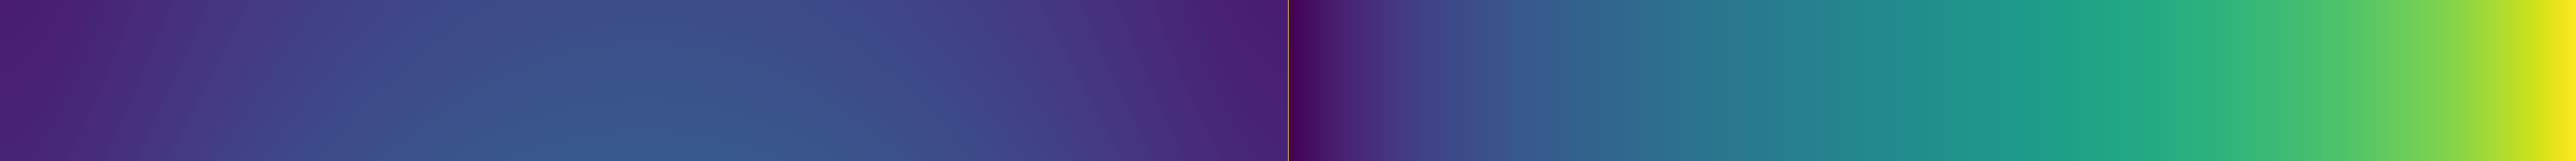

In [7]:
theta, phi = batch_from_loader['camera_pano']['rays'][0][0].numpy()

print('theta range: [{}, {}]'.format(theta.min(), theta.max()))
print('phi range: [{}, {}]'.format(phi.min(), phi.max()))

theta /= np.pi
phi /= 2 * np.pi

Image.fromarray(
    np.hstack([
        to_uint8(viz_photo(theta)), to_uint8(viz_photo(phi)),
    ])
)

## DEV: Visualize rays

### 1. Rays from ego-center

theta range: [0.7700938599106515, 1.7349464665018686]
phi range: [6.00637206638055e-08, 6.283182969352216]


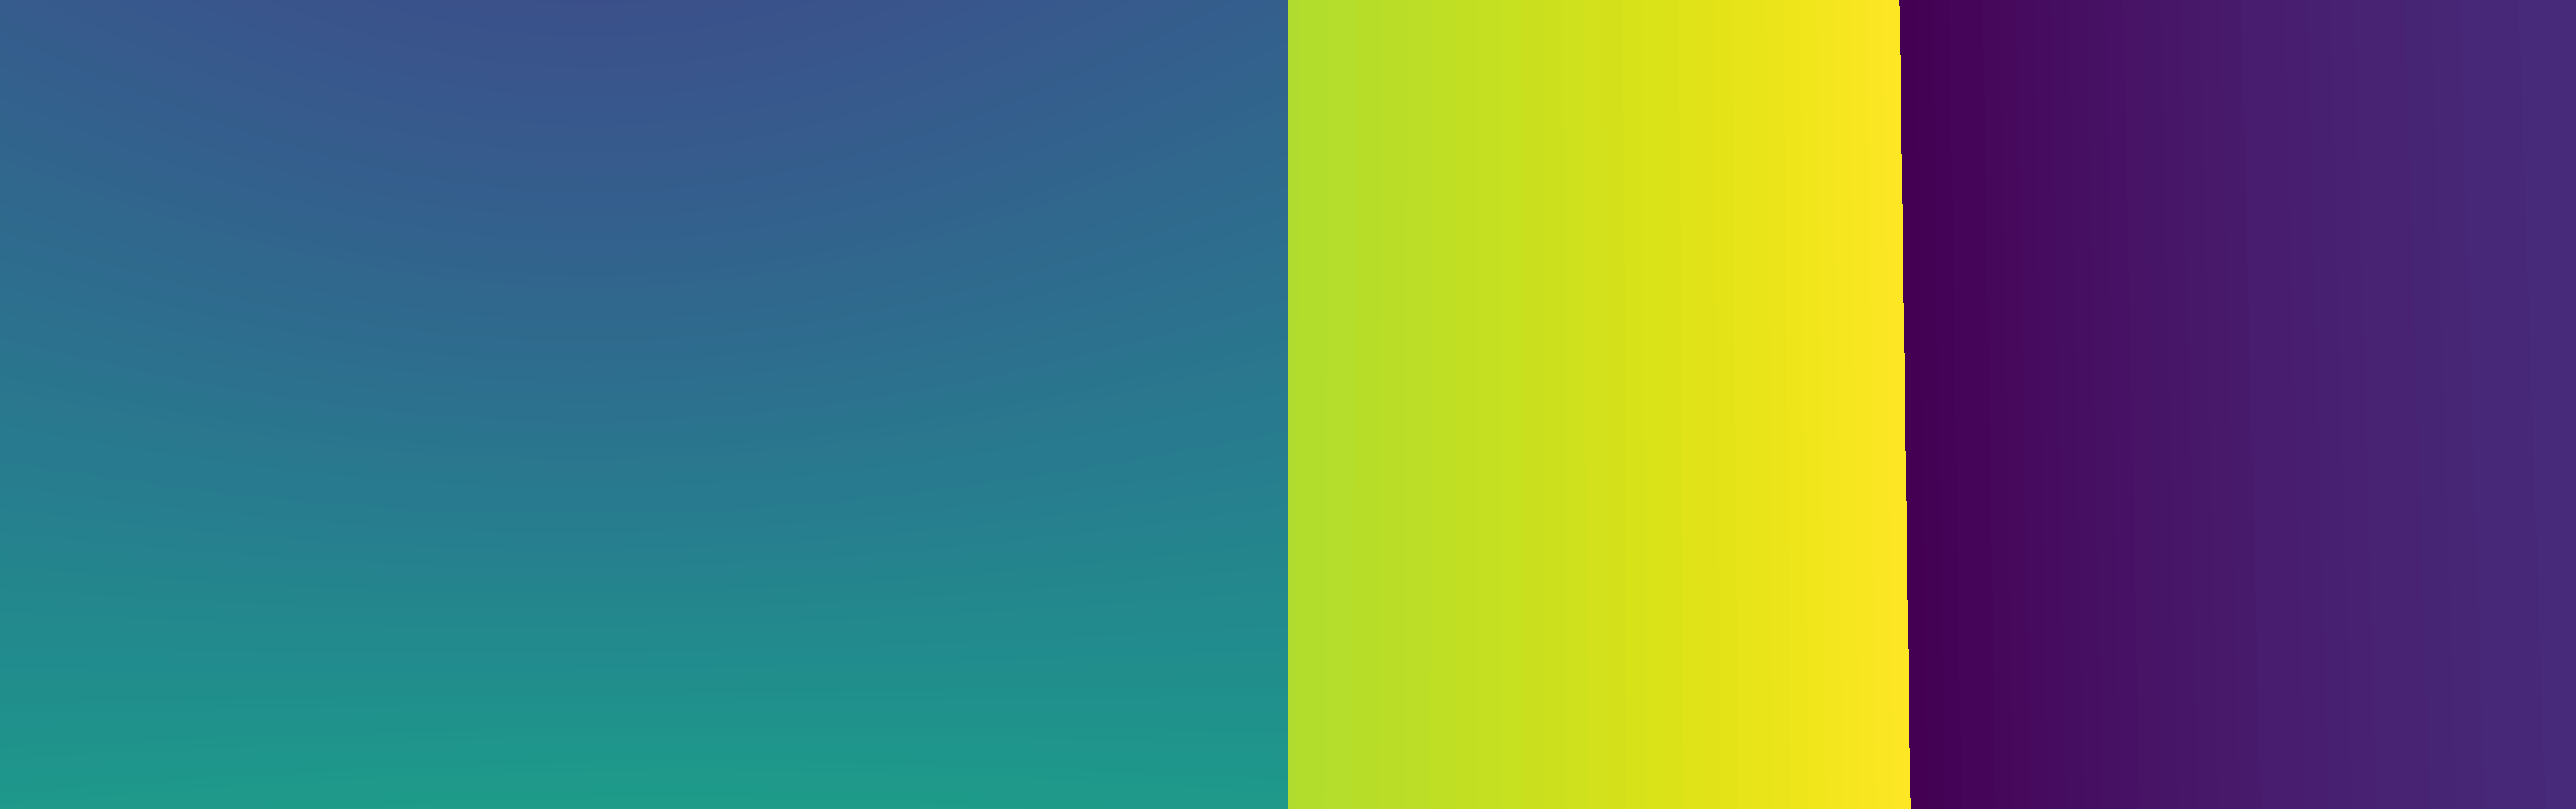

In [13]:
camera_idx = 5

theta, phi = dataset[0].create_camera_rays(camera_idx, distance=4.0, coord='ego')
print('theta range: [{}, {}]'.format(theta.min(), theta.max()))
print('phi range: [{}, {}]'.format(phi.min(), phi.max()))

theta /= np.pi
phi /= 2 * np.pi

Image.fromarray(
    np.hstack([
        to_uint8(viz_photo(theta)), to_uint8(viz_photo(phi)),
    ])
)

### 2. Rays from camera-center

theta range: [1.3048721714702436, 1.8481605292217813]
phi range: [2.6714458484641868, 3.5089141849909247]


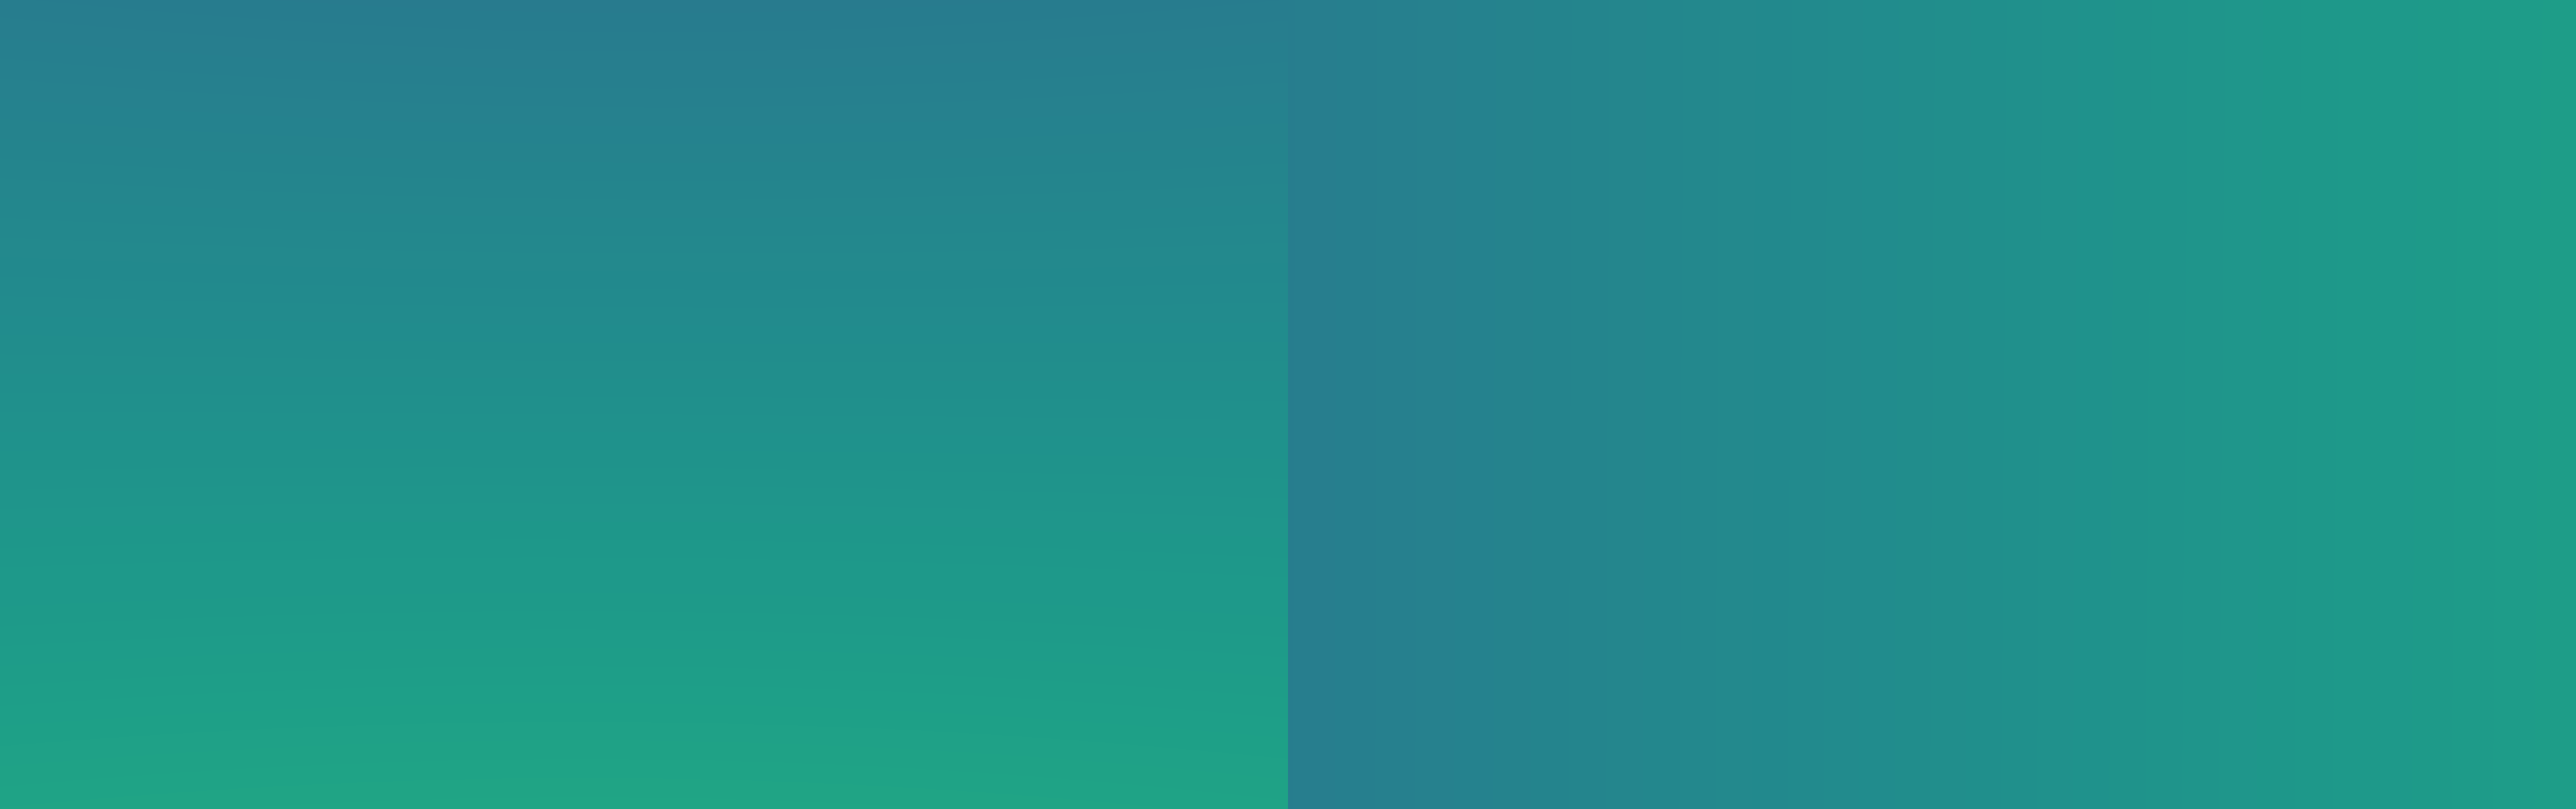

In [48]:
camera_idx = 0

theta, phi = dataset[0].create_camera_rays(camera_idx, distance=4.0, coord='cam')
print('theta range: [{}, {}]'.format(theta.min(), theta.max()))
print('phi range: [{}, {}]'.format(phi.min(), phi.max()))

theta /= np.pi
phi /= 2 * np.pi

Image.fromarray(
    np.hstack([
        to_uint8(viz_photo(theta)), to_uint8(viz_photo(phi)),
    ])
)

  0%|          | 0/29 [00:00<?, ?it/s]

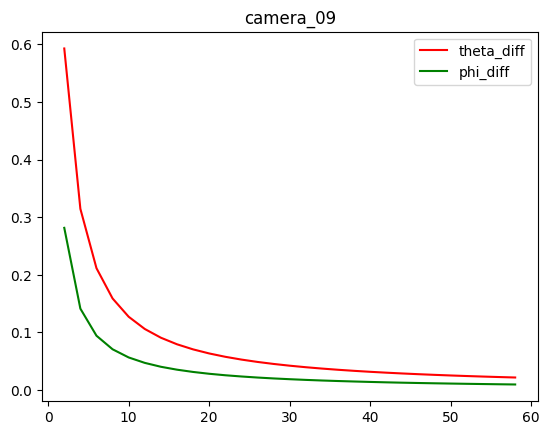

In [32]:
import matplotlib.pyplot as plt

camera_idx = 5

distances = range(2, 60, 2)
theta_diff = []
phi_diff = []

for dist in tqdm(distances):
    theta_ego, phi_ego = dataset[0].create_camera_rays(camera_idx, distance=dist, coord='ego')
    theta_cam, phi_cam = dataset[0].create_camera_rays(camera_idx, distance=dist, coord='cam')
    
    theta_diff.append( np.abs(theta_ego - theta_cam).mean() )
    phi_diff.append( np.abs(phi_ego - phi_cam).mean() )
    

h1 = plt.plot(distances, theta_diff, 'r', label='theta_diff')
h2 = plt.plot(distances, phi_diff, 'g', label='phi_diff')
plt.title(['camera_01', 'camera_05', 'camera_06', 'camera_07', 'camera_08', 'camera_09'][camera_idx])
plt.legend()

## Issue
- Without per-point depth values, we cannot calculate accurate rays from "ego-center"
- We can have rays from "camera-center" or pseudo-rays from ego-center with depth assumption.
- [ ] How different the rays are from "ego" and "center"?

In [10]:
# from vidar.geometry.camera_pano import PanoCamera

# intrinsics = batch_from_loader['camera_pano']['intrinsics'][0]
# hw = batch_from_loader['camera_pano']['hw']
# Twc = batch_from_loader['camera_pano']['Twc'][0]

# h, w = hw
# xyz_pano = PanoCamera(intrinsics, hw, Twc[None]).reconstruct_depth_map(1 * torch.ones([1, 1, h, w]), to_world=True)
# xyz_pano = xyz_pano.numpy().reshape(3, -1).T[::10]

# # Add pano
# theta, phi = dataset[0].create_pano_rays()
# theta /= np.pi
# phi /= 2 * np.pi

# rgb_pano = viz_photo(phi).reshape(-1, 3)[::10]

In [9]:
distance = 1.0
theta, phi = dataset[0].create_pano_rays(distance)
theta /= np.pi
phi /= 2 * np.pi

pcl = dataset[0].panodepth_to_points(distance)

xyz_pano = pcl[::10]
# rgb = viz_photo(theta).reshape(-1, 3)[::10]    
rgb_pano = viz_photo(phi).reshape(-1, 3)[::10]

# visualize_3d(xyz, rgb, size=0.1)

In [14]:
# def get_xyz_rgb(camera_idx, distance = 10.0, coord = 'ego'):
#     theta, phi = dataset[0].create_camera_rays(camera_idx, distance, coord)
#     theta /= np.pi
#     phi /= 2 * np.pi

#     image_shape = dataset[0].get_current('rgb', camera_idx).size[::-1]
#     pcl = dataset[0].depth_to_points(distance * np.ones(image_shape), camera_idx, coord)

#     xyz = pcl[::10]
#     # rgb = viz_photo(theta).reshape(-1, 3)[::10]    
#     rgb = viz_photo(phi).reshape(-1, 3)[::10]
#     return xyz, rgb
    

# xyz_all = []
# rgb_all = []
# camera_idx = 0
# for distance in tqdm([0.5, 2.0, 5.0, 10.0]):
#     xyz, rgb = get_xyz_rgb(camera_idx, distance)
#     xyz_all.append(xyz)
#     rgb_all.append(rgb)

# xyz_all += [batch_from_loader['lidar_pointcloud'][0]]
# rgb_all += [np.zeros_like(batch_from_loader['lidar_pointcloud'][0])]

# xyz_all = np.vstack(xyz_all)
# rgb_all = np.vstack(rgb_all)

# visualize_3d(xyz_all, rgb_all, size=0.2)

  0%|          | 0/4 [00:00<?, ?it/s]

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(0.0, 0.0,…

In [15]:
# camera_idx = 5
# distance = 5.0
# coord = 'ego'

def get_xyz_rgb(camera_idx, distance = 2.0, coord = 'ego'):
    theta, phi = dataset[0].create_camera_rays(camera_idx, distance, coord)
    theta /= np.pi
    phi /= 2 * np.pi

    image_shape = dataset[0].get_current('rgb', camera_idx).size[::-1]
    pcl = dataset[0].depth_to_points(distance * np.ones(image_shape), camera_idx, coord)

    xyz = pcl[::10]
    # rgb = viz_photo(theta).reshape(-1, 3)[::10]    
    rgb = viz_photo(phi).reshape(-1, 3)[::10]
    return xyz, rgb
    

xyz_all = []
rgb_all = []
for camera_idx in tqdm(range(6)):
    xyz, rgb = get_xyz_rgb(camera_idx)
    xyz_all.append(xyz)
    rgb_all.append(rgb)


xyz_all += [xyz_pano]
rgb_all += [rgb_pano]

xyz_all += [batch_from_loader['lidar_pointcloud'][0]]
rgb_all += [np.zeros_like(batch_from_loader['lidar_pointcloud'][0])]

xyz_all = np.vstack(xyz_all)
rgb_all = np.vstack(rgb_all)

visualize_3d(xyz_all, rgb_all, size=0.2)

  0%|          | 0/6 [00:00<?, ?it/s]

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(0.0, 0.0,…

In [13]:
dataset[0]

'panocam_150_z_-02_+02'

In [43]:
np.vstack([
    batch_from_loader[cam]['extrinsics'][0][0, :3, 3] for cam in ['camera_01', 'camera_05', 'camera_06', 'camera_07', 'camera_08', 'camera_09']
]).mean(axis=0)

array([ 0.0224,  1.5579, -0.5635], dtype=float32)

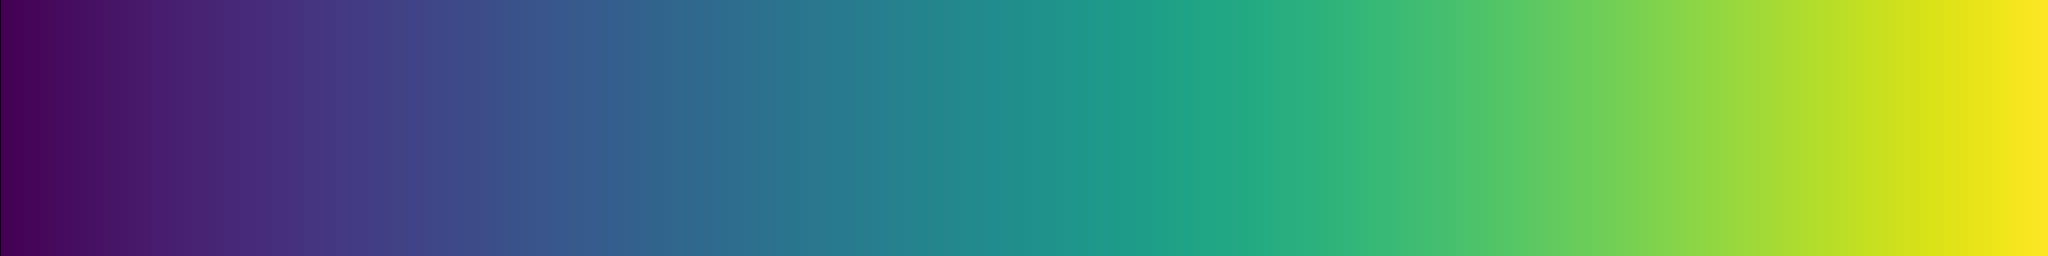

In [10]:
Image.fromarray(
    to_uint8(viz_photo(phi))
)

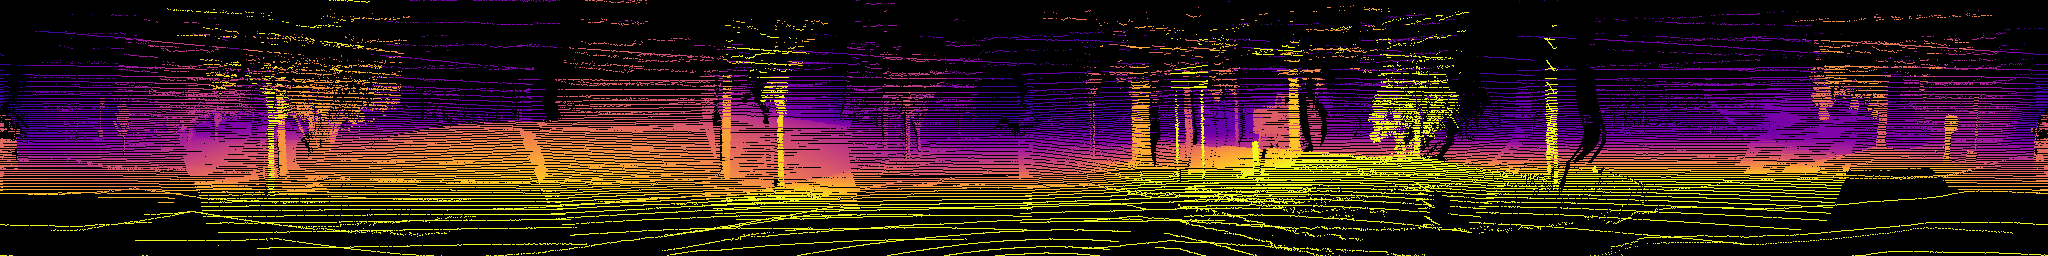

In [11]:
## position_in_world: [0, 0, 1.5]
Image.fromarray(
    to_uint8(viz_depth(batch_from_loader['camera_pano']['depth'][0][0]))
)

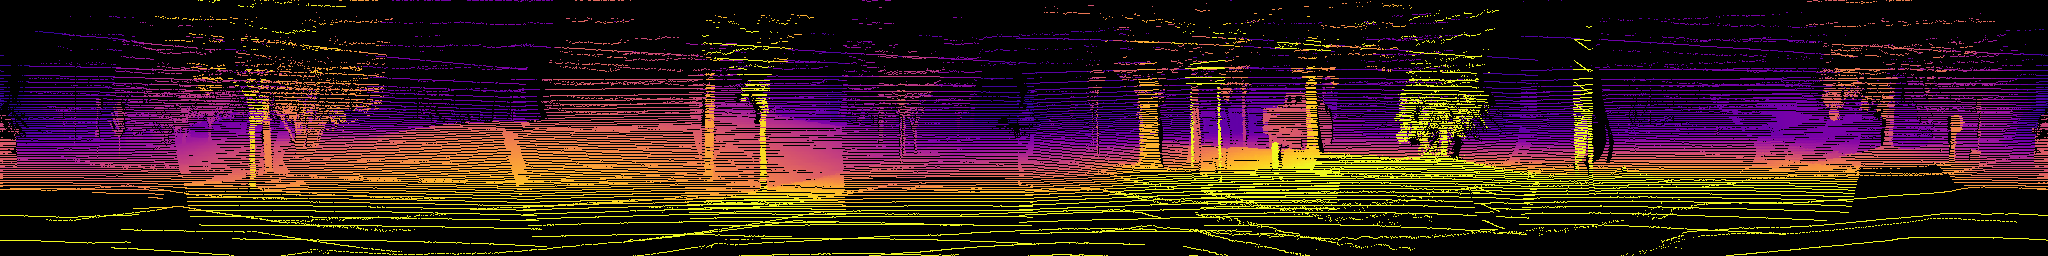

In [9]:
## position_in_world: [0.7, 0, 1.5]
Image.fromarray(
    to_uint8(viz_depth(batch_from_loader['camera_pano']['depth'][0][0]))
)

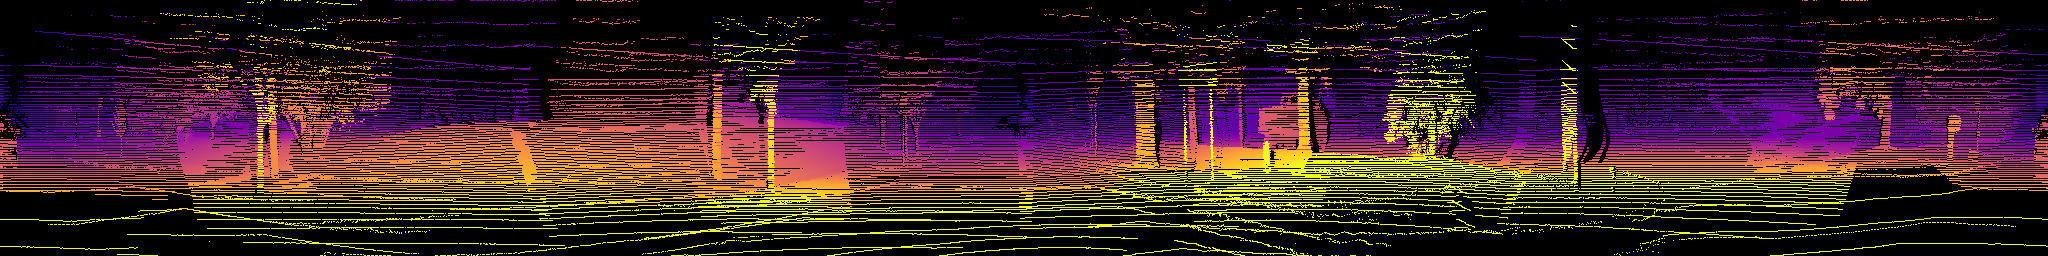

In [11]:
## position_in_world: [056, 0, 1.5]
Image.fromarray(
    to_uint8(viz_depth(batch_from_loader['camera_pano']['depth'][0][0]))
)

# Check attention map

In [254]:
dataset[0].create_pano_rays(distance=10.0)[1].max()

6.283185

In [264]:
batch_from_loader['camera_pano']['rays'][0][0, 1].max()

tensor(6.2832)

In [260]:
batch_from_loader['camera_09']['rays'][0][0, 1].max()

tensor(6.2832, dtype=torch.float64)

In [383]:
import torch.nn.functional as F

query_raw = F.interpolate(batch_from_loader['camera_pano']['rays'][0], scale_factor=1/16)
key_raw = F.interpolate(batch_from_loader['camera_05']['rays'][0], scale_factor=1/16)
# query_raw = batch_from_loader['camera_pano']['rays'][0]
# key_raw = batch_from_loader['camera_09']['rays'][0]


In [440]:
# query = torch.concat([torch.sin(query_raw[:, 1:]), torch.cos(query_raw[:, 1:])], axis=1)
# key = torch.concat([torch.sin(key_raw[:, 1:]), torch.cos(key_raw[:, 1:])], axis=1)

query = torch.concat([torch.sin(query_raw), torch.cos(query_raw)], axis=1)
key = torch.concat([torch.sin(key_raw), torch.cos(key_raw)], axis=1)

In [441]:
qH, qW = query.shape[-2:]
kH, kW = key.shape[-2:]

In [386]:
# display(Image.fromarray(
#     to_uint8(viz_photo(query_raw[0, 1]))
# ).resize((2024, 256)))
# display(Image.fromarray(
#     to_uint8(viz_photo(query[0, 1]))
# ))

# display(Image.fromarray(
#     to_uint8(viz_photo(key_raw[0, 1]))
# ))
# Image.fromarray(
#     to_uint8(viz_photo(key[0, 1]))
# )

In [442]:
# query_raw[0, 1, 8, :]

In [443]:
q = query.permute(0, 2, 3, 1).reshape(1, -1, 4).float()
k = key.permute(0, 2, 3, 1).reshape(1, -1, 4).float()

In [444]:
# attn = (q @ k.transpose(-2, -1)).softmax(dim=-1)
attn = (q @ k.transpose(-2, -1))
attn.shape

torch.Size([1, 2048, 960])

In [445]:
attn.min()

tensor(-1.0554)

In [446]:
attn.max()

tensor(1.9758)

In [447]:
attn.shape

torch.Size([1, 2048, 960])

In [448]:
attn.softmax(dim=-1).max()

tensor(0.0024)

(-1.0, 1.0)

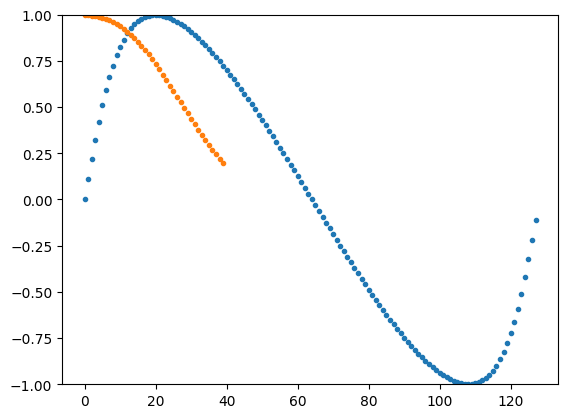

In [449]:
import matplotlib.pyplot as plt
# plt.plot(query_raw[0, 1, 8, :].numpy(), '.'); plt.ylim([0, 2 * np.pi])
# plt.plot(key_raw[0, 1, 8, :].numpy(), '.'); plt.ylim([0, 2 * np.pi])

plt.plot(query[0, 1, 8, :].numpy(), '.'); plt.ylim([-1, 1])
plt.plot(key[0, 1, 8, :].numpy(), '.'); plt.ylim([-1, 1])

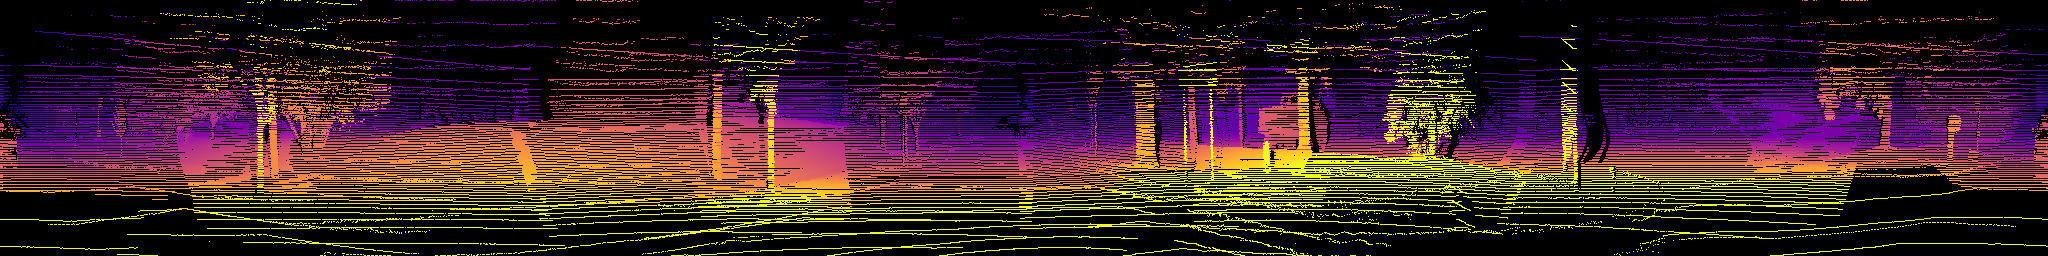

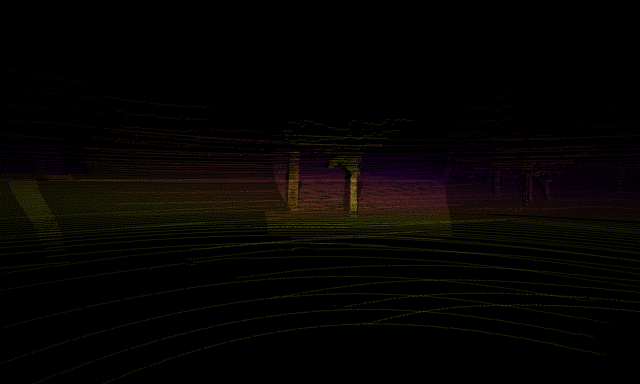

In [439]:
Image.fromarray(
    to_uint8(viz_depth(batch_from_loader['camera_05']['depth'][0][0], normalizer=normalizer))
).resize( (kW * 16, kH * 16) )

In [400]:
inv_depth = depth2inv(batch_from_loader['camera_pano']['depth'][0][0])
normalizer = np.percentile(inv_depth, 95)

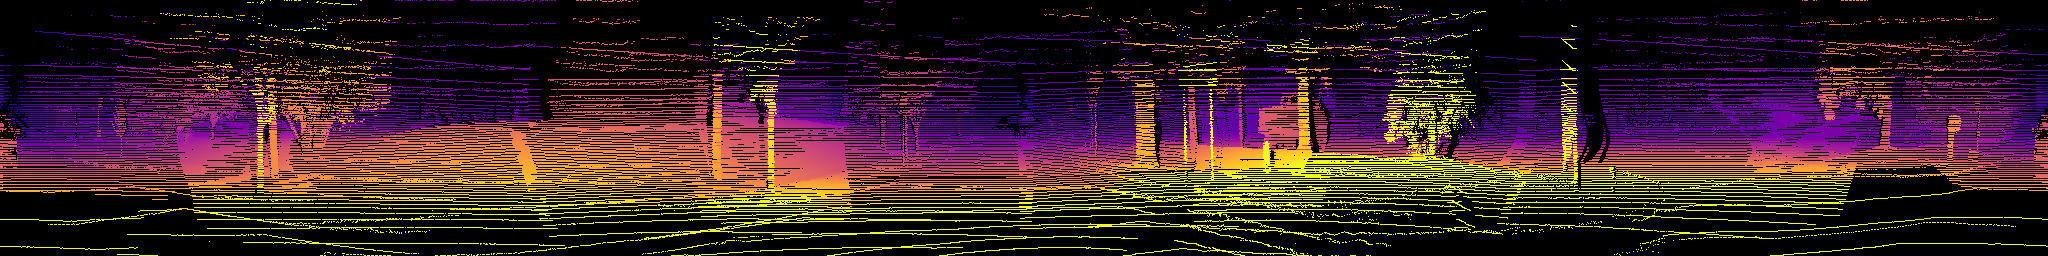

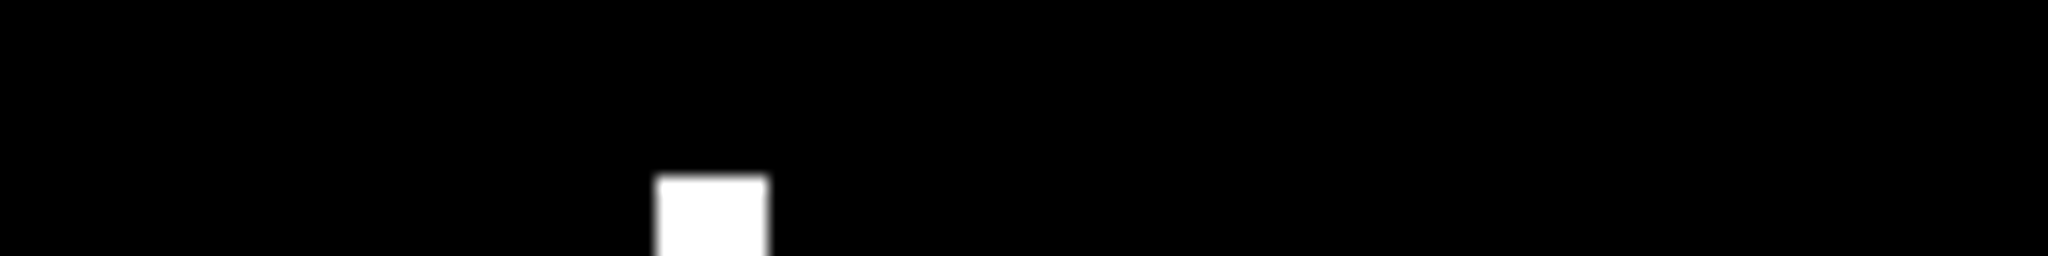

In [456]:
refpoint = (int(qH / 10 * 9), int(qW / 100 * 35))
ref = np.zeros((qH, qW, 3), dtype=np.uint8)

for oy in range(-3, 4):
    for ox in range(-3, 4):
        ref[max(0, min(qH-1, refpoint[0] + oy)), max(0, min(qW-1, refpoint[1] + ox))] = 255

display(Image.fromarray(
    to_uint8(viz_depth(batch_from_loader['camera_pano']['depth'][0][0], normalizer=normalizer))
))
Image.fromarray(ref).resize( (qW*16, qH*16) )

tensor(0.9343)


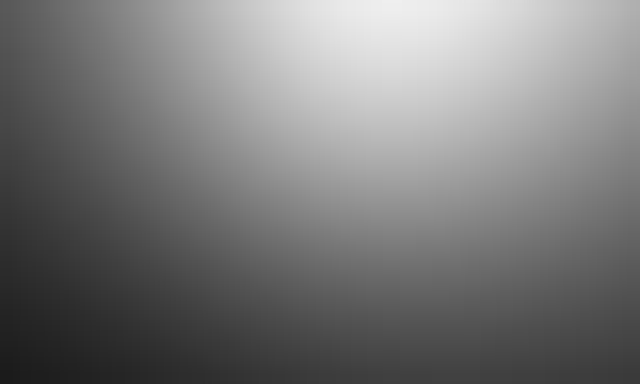

In [457]:
attn0 = attn.reshape(qH, qW, kH, kW)[refpoint[0], refpoint[1]]
# attn0 = ((attn0 + 1) / 2)
attn0 = attn0 / 2
# attn_viz = torch.tanh(attn0)
# attn_viz = attn0
# attn_viz = np.power(attn0, 8)
attn_viz = np.exp(5 * attn0 - 5)

# attn0 = (attn0 + 1) / 2
print(attn_viz.max())

Image.fromarray(
    to_uint8(attn_viz.cpu().numpy())
).resize( (kW * 16, kH * 16) )

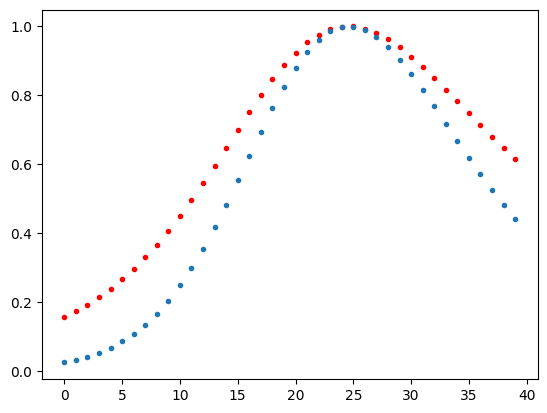

In [438]:
plt.plot(np.exp(5 * attn0[12, :] - 5), '.r')
plt.plot(attn0[12, :] ** 8, '.')

In [194]:
query_raw[:, :, refpoint[0], refpoint[1]]

tensor([[0.2562, 0.5050]])

In [195]:
query[:, :, refpoint[0], refpoint[1]]

tensor([[0.4838, 0.8752]])

In [198]:
key[:, 0, :, :]

tensor([[[-0.6783, -0.6586, -0.6375, -0.6145, -0.5903, -0.5638, -0.5362,
          -0.5068, -0.4749, -0.4417, -0.4060, -0.3691, -0.3305, -0.2894,
          -0.2475, -0.2034, -0.1590, -0.1137, -0.0668, -0.0204,  0.0269,
           0.0730,  0.1186,  0.1643,  0.2080,  0.2513,  0.2923,  0.3316,
           0.3700,  0.4058,  0.4405,  0.4726,  0.5028,  0.5319,  0.5586,
           0.5841,  0.6076,  0.6295,  0.6503,  0.6694],
         [-0.6782, -0.6585, -0.6374, -0.6144, -0.5902, -0.5638, -0.5362,
          -0.5068, -0.4749, -0.4418, -0.4061, -0.3693, -0.3308, -0.2897,
          -0.2479, -0.2038, -0.1595, -0.1142, -0.0673, -0.0211,  0.0262,
           0.0723,  0.1179,  0.1636,  0.2072,  0.2505,  0.2914,  0.3308,
           0.3692,  0.4050,  0.4396,  0.4717,  0.5020,  0.5311,  0.5578,
           0.5834,  0.6069,  0.6288,  0.6497,  0.6688],
         [-0.6780, -0.6584, -0.6373, -0.6143, -0.5901, -0.5638, -0.5362,
          -0.5069, -0.4750, -0.4419, -0.4063, -0.3695, -0.3310, -0.2900,
          -0

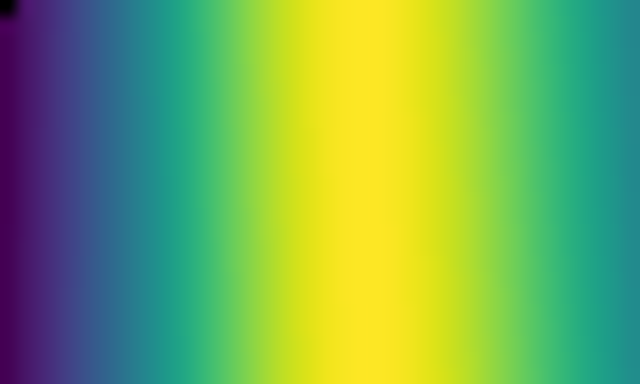

In [148]:
attn0 = attn[0, refpoint[0] + refpoint[1] * qH, :].reshape(kH, kW)
Image.fromarray(
    to_uint8(viz_photo(attn0.cpu().numpy(), normalize=True))
).resize( (kW * 16, kH * 16) )

In [ ]:
attn0 = attn[0, qH * 10 + qW //2, :].reshape(kH, kW)
Image.fromarray(
    to_uint8(viz_photo(attn0.cpu().numpy(), normalize=True))
).resize( (kW * 16, kH * 16) )

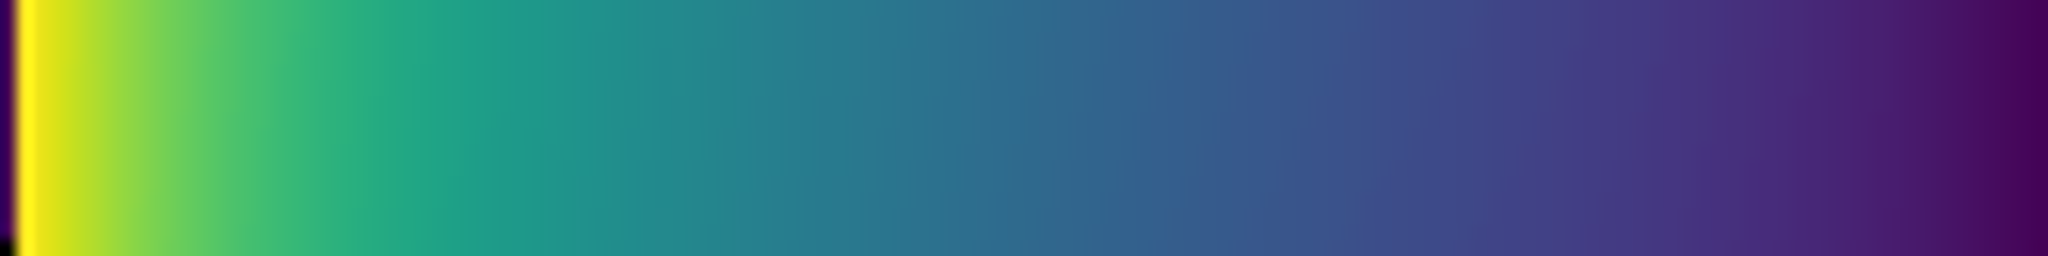

In [103]:
attn0 = attn[0, :, 24 * 5].reshape(qH, qW)
Image.fromarray(
    to_uint8(viz_photo(attn0.cpu().numpy(), normalize=True))
).resize( (qW * 16, qH * 16) )

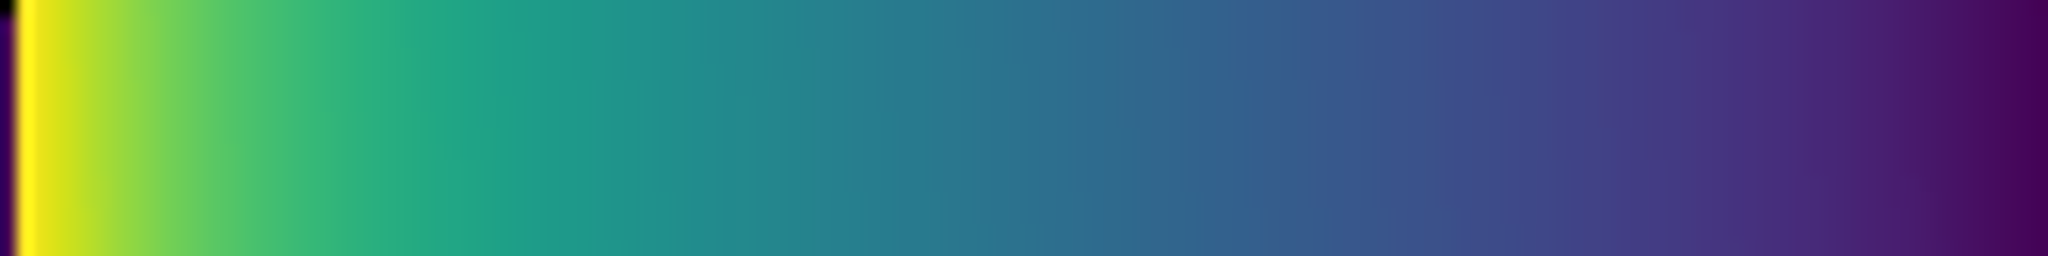

In [106]:
attn0 = attn[0, :, 24 * 15].reshape(qH, qW)
Image.fromarray(
    to_uint8(viz_photo(attn0.cpu().numpy(), normalize=True))
).resize( (qW * 16, qH * 16) )

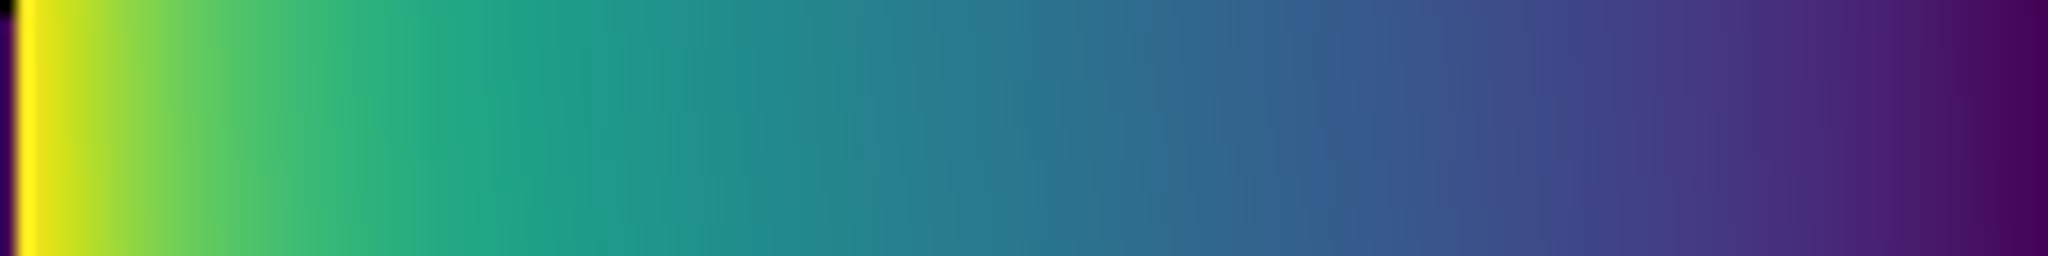

In [107]:
attn0 = attn[0, :, 24 * 25].reshape(qH, qW)
Image.fromarray(
    to_uint8(viz_photo(attn0.cpu().numpy(), normalize=True))
).resize( (qW * 16, qH * 16) )

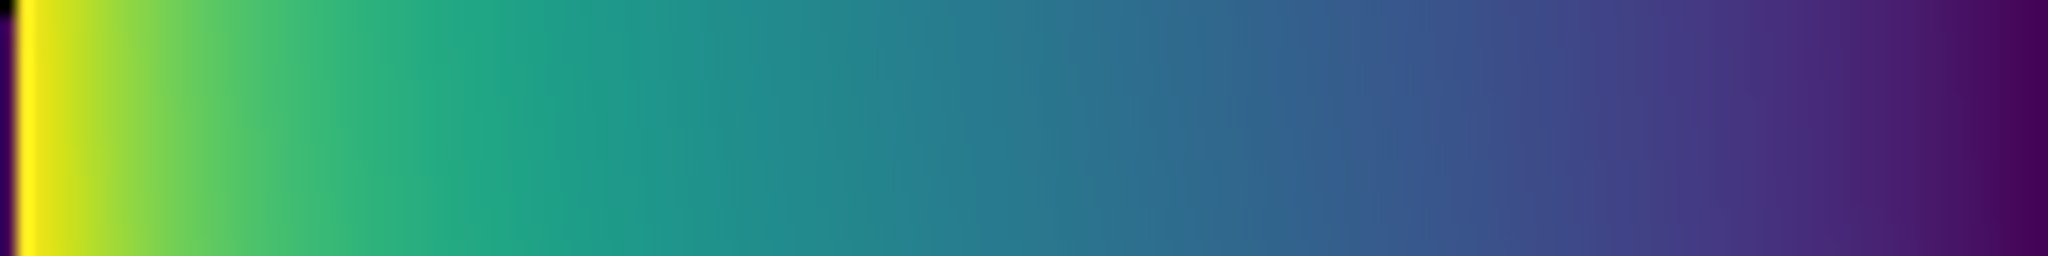

In [108]:
attn0 = attn[0, :, 24 * 35].reshape(qH, qW)
Image.fromarray(
    to_uint8(viz_photo(attn0.cpu().numpy(), normalize=True))
).resize( (qW * 16, qH * 16) )